# Data modelling 
**Part IV**

There are a few potential linear regression models based on the values on the heatmaps and scatterplots in the last part that consist of different combinations of Y(target) and X(predictor) variables. My first step will be to examine the summary statistics of each model with statsmodels and select the best one, while the second best one will be a baseline model.

While the purpose of this project was statistical modelling for the sake of modelling with linear regression, I do not expect this model to be the best performing model the many restrictions on ordinary least squares linear regression, forced me to exclude many other correlated features that could have contained valueable predictive data. I will attempt to create models with these other features, free of the restrictions of OLS in a part 5 file where all the features are included to obtain the best performing model.

Content:
- Checking Ordinary Least Squares assumptions

- Choosing the best model

- Metrics

- Baseline linear regression model

- Data train validate test split

- Linear regression model

- Other models

- Testing best model

- Conclusions


Models used:
* Linear Regression (OLS)
* Decision tree regressor
* Random forest regressor
* Elasic net regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
housing_raw = pd.read_csv('data/housing_processed.csv')

In [3]:
# Dropping  ocean_proximity_NEAR BAY to prevent collinearity between columns
# 0 0 0 0 is correlated with 1
housing_data = housing_raw[['median_house_value','log_median_house_value','sqrt_median_house_value','sqr_median_house_value','in_city','median_income', # main variables
                            'log_person/room','log_person/household', 'log_room/person', 'log_household/person',
                            'sqrt_person/room','sqrt_person/household', 'sqrt_room/person', 'sqrt_household/person',
                             'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND','ocean_proximity_ISLAND', 'ocean_proximity_NEAR OCEAN']] # ocean variables

## Checking OLS assumptions

1. No multicollinearity
2. Linearity
3. Normality and homoscedascity - check error plot for normal distribution

In [4]:
housing_data.corr()

,median_house_value,log_median_house_value,sqrt_median_house_value,sqr_median_house_value,in_city,median_income,log_person/room,log_person/household,log_room/person,log_household/person,sqrt_person/room,sqrt_person/household,sqrt_room/person,sqrt_household/person,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR OCEAN
median_house_value,1.000000,0.948833,0.988052,0.967221,0.437561,0.661582,-0.329794,-0.329794,0.329794,0.329794,-0.273260,-0.273260,0.298473,0.298473,0.259990,-0.487941,0.025140,0.141330
log_median_house_value,0.948833,1.000000,0.985811,0.843919,0.526243,0.661227,-0.293671,-0.293671,0.293671,0.293671,-0.246814,-0.246814,0.262192,0.262192,0.334656,-0.568445,0.021298,0.143738
sqrt_median_house_value,0.988052,0.985811,1.000000,0.918128,0.486562,0.670566,-0.316777,-0.316777,0.316777,0.316777,-0.264310,-0.264310,0.284708,0.284708,0.300694,-0.534545,0.023639,0.144359
sqr_median_house_value,0.967221,0.843919,0.918128,1.000000,0.341352,0.611559,-0.329916,-0.329916,0.329916,0.329916,-0.269827,-0.269827,0.302790,0.302790,0.182791,-0.389296,0.025709,0.128963
in_city,0.437561,0.526243,0.486562,0.341352,1.000000,0.276770,0.149876,0.149876,-0.149876,-0.149876,0.109084,0.109084,-0.160693,-0.160693,0.433192,-0.675880,0.010161,0.086790
median_income,0.661582,0.661227,0.670566,0.611559,0.276770,1.000000,-0.409055,-0.409055,0.409055,0.409055,-0.345864,-0.345864,0.359618,0.359618,0.178664,-0.239850,-0.009709,0.017607
log_person/room,-0.329794,-0.293671,-0.316777,-0.329916,0.149876,-0.409055,1.000000,1.000000,-1.000000,-1.000000,0.901330,0.901330,-0.949494,-0.949494,0.189462,-0.124827,-0.010226,-0.030161
log_person/household,-0.329794,-0.293671,-0.316777,-0.329916,0.149876,-0.409055,1.000000,1.000000,-1.000000,-1.000000,0.901330,0.901330,-0.949494,-0.949494,0.189462,-0.124827,-0.010226,-0.030161
log_room/person,0.329794,0.293671,0.316777,0.329916,-0.149876,0.409055,-1.000000,-1.000000,1.000000,1.000000,-0.901330,-0.901330,0.949494,0.949494,-0.189462,0.124827,0.010226,0.030161
log_household/person,0.329794,0.293671,0.316777,0.329916,-0.149876,0.409055,-1.000000,-1.000000,1.000000,1.000000,-0.901330,-0.901330,0.949494,0.949494,-0.189462,0.124827,0.010226,0.030161


In [5]:
# checking multilinearity
housing_data[['log_person/room','log_person/household', 'log_room/person', 'log_household/person',
                            'sqrt_person/room','sqrt_person/household', 'sqrt_room/person', 'sqrt_household/person']].corr().style.background_gradient()

,log_person/room,log_person/household,log_room/person,log_household/person,sqrt_person/room,sqrt_person/household,sqrt_room/person,sqrt_household/person
log_person/room,1.000000,1.000000,-1.000000,-1.000000,0.901330,0.901330,-0.949494,-0.949494
log_person/household,1.000000,1.000000,-1.000000,-1.000000,0.901330,0.901330,-0.949494,-0.949494
log_room/person,-1.000000,-1.000000,1.000000,1.000000,-0.901330,-0.901330,0.949494,0.949494
log_household/person,-1.000000,-1.000000,1.000000,1.000000,-0.901330,-0.901330,0.949494,0.949494
sqrt_person/room,0.901330,0.901330,-0.901330,-0.901330,1.000000,1.000000,-0.769916,-0.769916
sqrt_person/household,0.901330,0.901330,-0.901330,-0.901330,1.000000,1.000000,-0.769916,-0.769916
sqrt_room/person,-0.949494,-0.949494,0.949494,0.949494,-0.769916,-0.769916,1.000000,1.000000
sqrt_household/person,-0.949494,-0.949494,0.949494,0.949494,-0.769916,-0.769916,1.000000,1.000000


Correlation among these features are high, A model can only use:

log person/room

or

sqrt person/room
sqrt room/person


In [6]:
variables = housing_data[['log_median_house_value','log_person/room','in_city', 'median_income']]

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif

,VIF,Features
0,9.932047,log_median_house_value
1,4.600910,log_person/room
2,4.218852,in_city
3,9.317045,median_income


In [7]:
variables = housing_data[['median_house_value','log_person/room','in_city', 'median_income']]

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif

,VIF,Features
0,9.224259,median_house_value
1,4.168158,log_person/room
2,4.007787,in_city
3,10.304591,median_income


In [8]:
variables = housing_data[['sqr_median_house_value','sqrt_person/room','sqrt_room/person','in_city', 'median_income']]

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif

,VIF,Features
0,3.126505,sqr_median_house_value
1,0.442692,sqrt_person/room
2,12.093995,sqrt_room/person
3,1.237030,in_city
4,1.724399,median_income


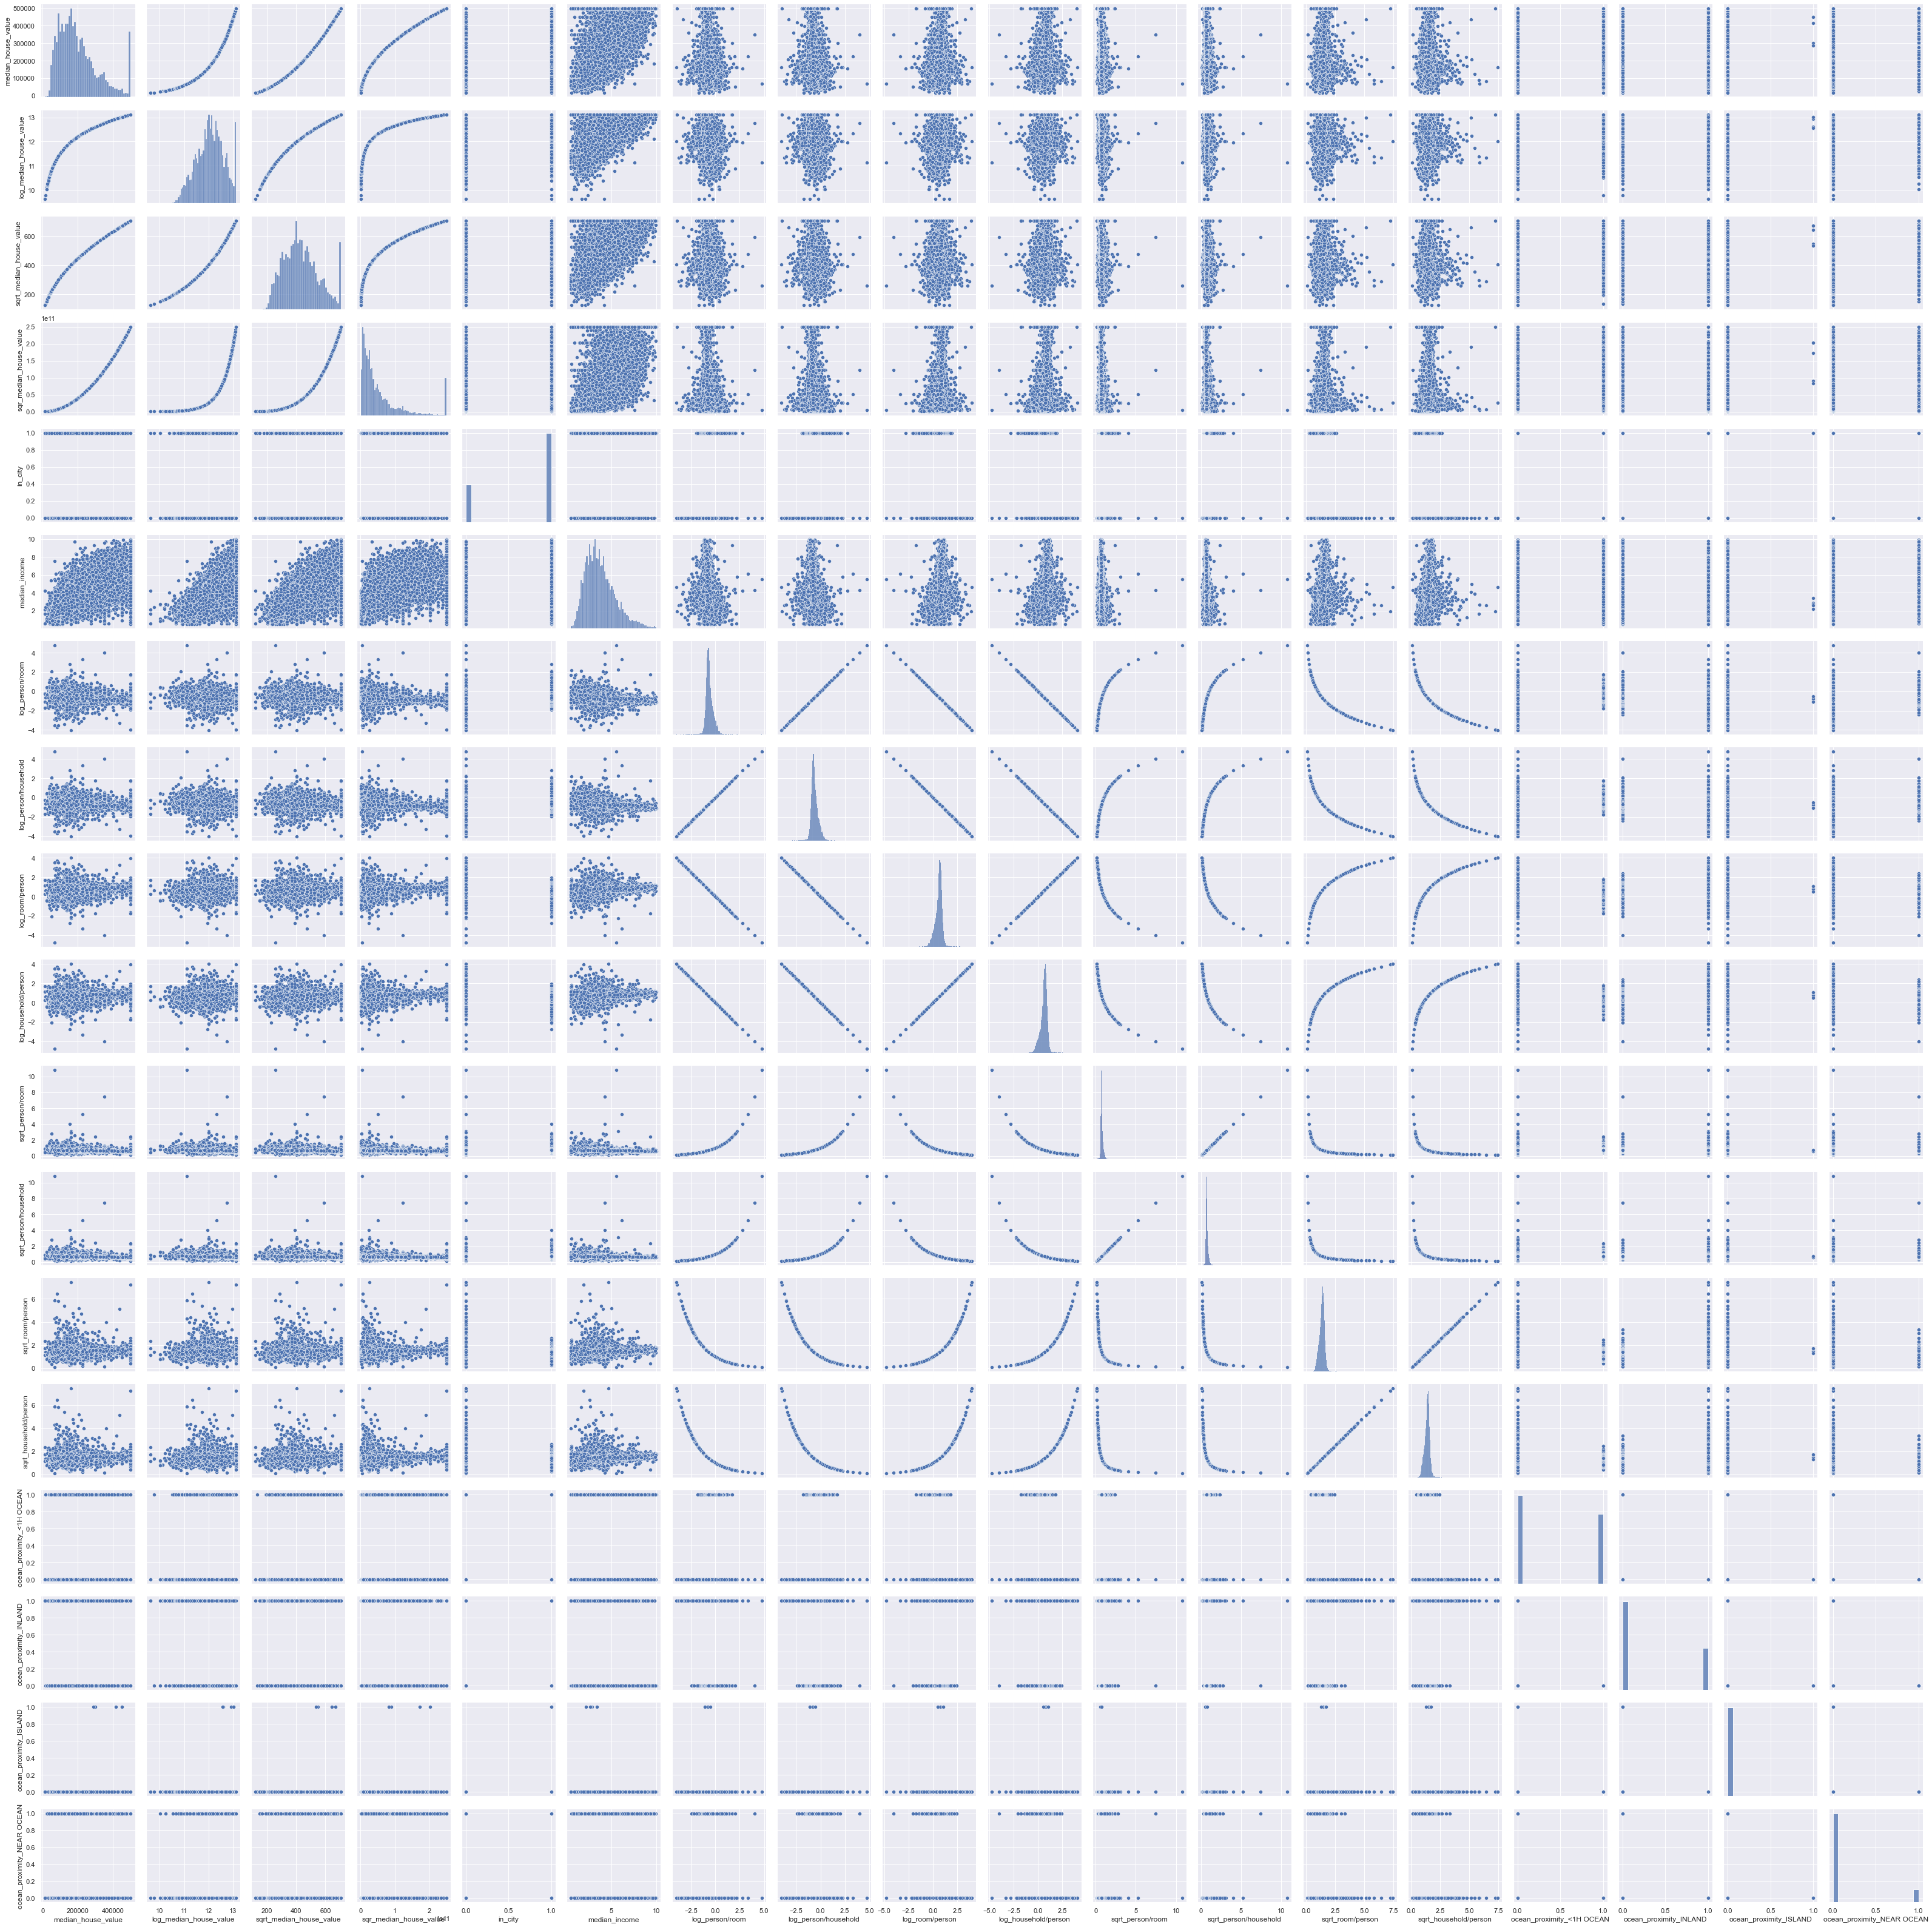

In [9]:
# Checking linearity
sns.pairplot(housing_data)
plt.show()

## Choosing the best model to use
The models have been carefully selected from examining the pairplot. I obtained 3 potential models to use:

* ['log_median_house_value','log_person/room','in_city', 'median_income','ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND','ocean_proximity_ISLAND', 'ocean_proximity_NEAR OCEAN']

* ['median_house_value','log_person/room','in_city', 'median_income','ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND','ocean_proximity_ISLAND', 'ocean_proximity_NEAR OCEAN']

* ['sqr_median_house_value','sqrt_person/room','sqrt_room/person','in_city', 'median_income', 'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND','ocean_proximity_ISLAND', 'ocean_proximity_NEAR OCEAN']

I will use the statsmodels ols module to calculate the summary tatistics of the model as sklearn does not have an easy to use function

In [10]:
for model in [['log_median_house_value','log_person/room','in_city', 'median_income','ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND','ocean_proximity_ISLAND', 'ocean_proximity_NEAR OCEAN'],
              ['median_house_value','log_person/room','in_city', 'median_income','ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND','ocean_proximity_ISLAND', 'ocean_proximity_NEAR OCEAN'],
              ['sqr_median_house_value','sqrt_person/room','sqrt_room/person','in_city', 'median_income', 'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND','ocean_proximity_ISLAND', 'ocean_proximity_NEAR OCEAN']]:
    
    y = housing_data[[model[0]]]
    x_before = housing_data[model[1:]]
    x = sm.add_constant(x_before)
    
    model1 = sm.OLS(y,x).fit()
    print(model1.summary())
    print('\n')

                              OLS Regression Results                              
Dep. Variable:     log_median_house_value   R-squared:                       0.653
Model:                                OLS   Adj. R-squared:                  0.653
Method:                     Least Squares   F-statistic:                     5463.
Date:                    Tue, 04 May 2021   Prob (F-statistic):               0.00
Time:                            14:51:05   Log-Likelihood:                -6290.3
No. Observations:                   20332   AIC:                         1.260e+04
Df Residuals:                       20324   BIC:                         1.266e+04
Df Model:                               7                                         
Covariance Type:                nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [11]:
x = housing_data[['log_person/room','in_city', 'median_income', 'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND','ocean_proximity_ISLAND', 'ocean_proximity_NEAR OCEAN']]
y = housing_data[['log_median_house_value']]

In [12]:
x_baseline = housing_data[['log_person/room','in_city', 'median_income','ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND','ocean_proximity_ISLAND', 'ocean_proximity_NEAR OCEAN']]
y_baseline = housing_data[['median_house_value']]

## Metrics
MSE is highly biased for higher values. RMSE is better in terms of reflecting performance when dealing with large error values. MAE is less biased for higher values

I will use RMSE as it is the 'gentlest' metric that is the best in dealing with large error values which is appripriate for a high variance dataset like this. I will use MAE too

In [13]:
def rmse(y_actual, y_hat):
    return np.sqrt(mean_squared_error(y_actual, y_hat))

def mae(y_actual, y_hat):
    return mean_absolute_error(y_actual, y_hat)

In [14]:
rmse(np.array([1,2,3,4]), np.array([3,4,5,6]))

2.0

## Baseline linear regression model
With model 2 

In [15]:
reg = LinearRegression(normalize=True)
reg.fit(x_baseline, y_baseline)
reg.score(x_baseline, y_baseline)

0.5868770498619965

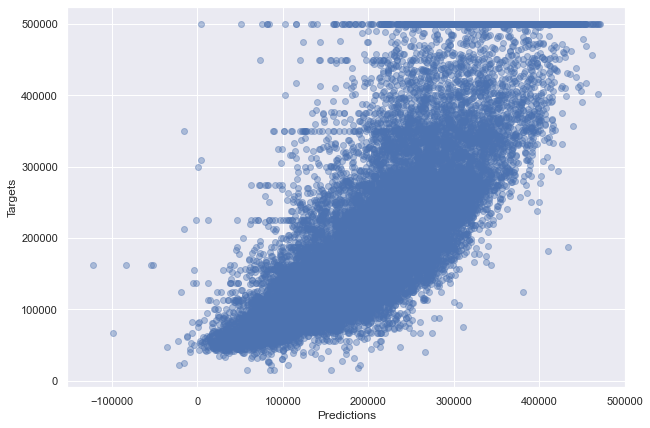

RMSE: 71277.49817026693
MAE: 52071.59931955729


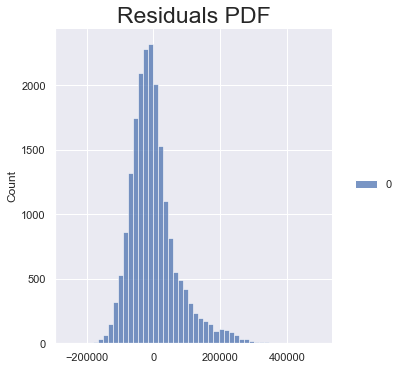

In [16]:
y_hat = reg.predict(x_baseline)

plt.figure(figsize=(10,7))
plt.scatter(y_hat, y_baseline, alpha=.4)
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.show()
print('RMSE:', rmse(y_baseline, y_hat))
print('MAE:', mae(y_baseline, y_hat))
sns.displot(y_baseline.values - y_hat, bins=50)
plt.title("Residuals PDF", size=23)
plt.show()

## Train validate test split
Train - used to train models

Validate - used to tune models

Test - used to test best model

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
x_validate, x_test, y_validate, y_test = train_test_split(x_test, y_test, test_size=0.5)
print(len(x_train), len(y_train))
print(len(x_validate), len(y_validate))
print(len(x_test), len(y_test))

14232 14232
3050 3050
3050 3050


## Linear regression model
The scatter plot plots the predicted value of Y against the observed (real) values of Y. A perfect prediction would be result in a straight thin 45 degree line, while errors deviate from the 45 degree line.

The errors are plotted on a count plot and are supposed to resemble the bell curve of the gaussian distribution

In [18]:
reg = LinearRegression(normalize=True)
reg.fit(x_train,y_train)
reg.score(x_train,y_train)
# I chose to use normalize=True to normalize the data instead of using the 
# standardscaler as recommended on https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

0.6574521884312734

training data


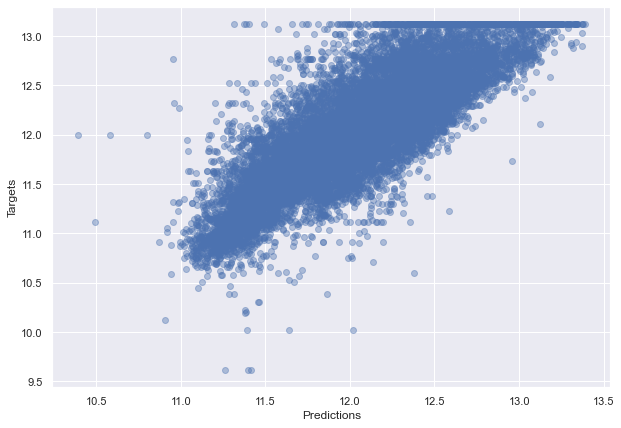

RMSE: 0.3292201880261472
MAE: 0.2537576535229904


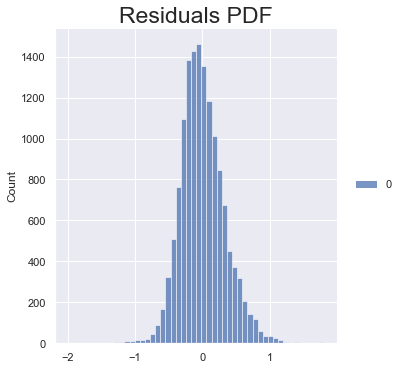

In [19]:
print('training data')
y_hat = reg.predict(x_train)

plt.figure(figsize=(10,7))
plt.scatter(y_hat, y_train, alpha=.4)
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.show()
print('RMSE:', rmse(y_train, y_hat))
print('MAE:', mae(y_train, y_hat))
sns.displot(y_train.values - y_hat, bins=50)
plt.title("Residuals PDF", size=23)
plt.show()

validating data


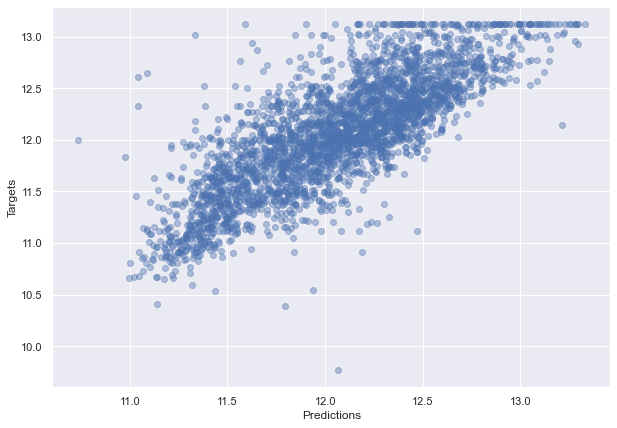

RMSE: 0.33292233306062025
MAE: 0.2563881358041232


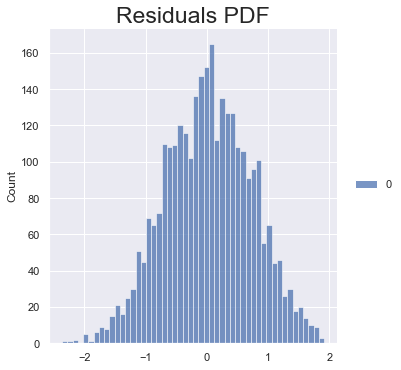

In [20]:
print('validating data')
y_hat = reg.predict(x_validate)

plt.figure(figsize=(10,7))
plt.scatter(y_hat, y_validate, alpha=.4)
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.show()
print('RMSE:', rmse(y_validate, y_hat))
print('MAE:', mae(y_validate, y_hat))

sns.displot(y_test.values - y_hat, bins=50)
plt.title("Residuals PDF", size=23)
plt.show()

In [21]:
y_table = y_validate.copy()
y_table['actual y'] = np.exp(y_table['log_median_house_value'])
y_table['predicted y'] = np.exp(y_hat)
y_table['difference'] = np.abs(y_table['actual y']-y_table['predicted y'])
y_table['difference %'] = y_table['difference']/y_table['predicted y']

y_table

,log_median_house_value,actual y,predicted y,difference,difference %
17954,12.191974,197200.0,214665.845481,17465.845481,0.081363
2484,10.915088,55000.0,77349.909191,22349.909191,0.288946
18868,12.690657,324700.0,361264.568628,36564.568628,0.101213
989,12.286731,216800.0,170869.250381,45930.749619,0.268806
733,12.145792,188300.0,258361.834268,70061.834268,0.271177
...,...,...,...,...,...
19819,11.656160,115400.0,73085.345586,42314.654414,0.578976
4367,12.023951,166700.0,127844.154804,38855.845196,0.303931
2335,11.800358,133300.0,104093.607771,29206.392229,0.280578
15391,12.038246,169100.0,181663.784613,12563.784613,0.069160


In [22]:
print('mean % difference: {}'.format(y_table['difference %'].mean()))
print('mean difference: {}'.format(y_table['difference'].mean()))

mean % difference: 0.2763251773847301
mean difference: 49441.1625332185


## Decision tree regression model

In [23]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train)

param_grid = {'criterion':['mse','friedman_mse'], 
              'max_depth':list(range(8,15)), 
              'min_samples_split':[2, 1, 0.01, 0.0025, 0.005],
              'min_samples_leaf':[3, 2, 1, 0.0025, 0.005, 0.01], 
              'max_features':[1,2,3]}

gridsearch_dtr = GridSearchCV(estimator = dtr,
                     param_grid = param_grid,
                     scoring = 'neg_root_mean_squared_error',
                     n_jobs = 6,
                     cv = None, #Turning off cross fold validation for performance
                     refit= True, 
                     return_train_score = False)

gridsearch_dtr.fit(x_train, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=6,
             param_grid={'criterion': ['mse', 'friedman_mse'],
                         'max_depth': [8, 9, 10, 11, 12, 13, 14],
                         'max_features': [1, 2, 3],
                         'min_samples_leaf': [3, 2, 1, 0.0025, 0.005, 0.01],
                         'min_samples_split': [2, 1, 0.01, 0.0025, 0.005]},
             scoring='neg_root_mean_squared_error')

In [24]:
print(gridsearch_dtr.best_params_)

{'criterion': 'mse', 'max_depth': 14, 'max_features': 3, 'min_samples_leaf': 0.005, 'min_samples_split': 0.0025}


training data


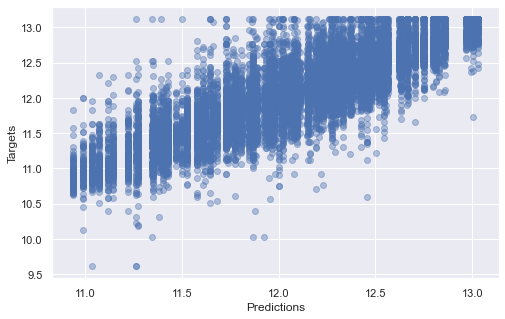

RMSE: 0.3116642235325157
MAE: 0.23619653386944953
testing data


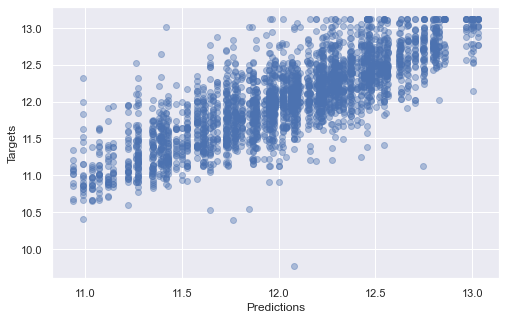

RMSE: 0.325383310645007
MAE: 0.5841801643575838


In [25]:
print('training data')
y_hat = gridsearch_dtr.best_estimator_.predict(x_train)

plt.figure(figsize=(8,5))
plt.scatter(y_hat, y_train, alpha=.4)
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.show()

print('RMSE:', np.sqrt(mean_squared_error(y_train, y_hat)))
print('MAE:', mean_absolute_error(y_train, y_hat))

print('testing data')
y_hat = gridsearch_dtr.best_estimator_.predict(x_validate)

plt.figure(figsize=(8,5))
plt.scatter(y_hat, y_validate, alpha=.4)
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.show()

print('RMSE:', np.sqrt(mean_squared_error(y_validate, y_hat)))
print('MAE:', mean_absolute_error(y_test, y_hat))

In [26]:
y_table = y_validate.copy()
y_table['actual y'] = np.exp(y_table['log_median_house_value'])
y_table['predicted y'] = np.exp(y_hat)
y_table['difference'] = np.abs(y_table['actual y']-y_table['predicted y'])
y_table['difference %'] = y_table['difference']/y_table['predicted y']

print('mean % difference: {}'.format(y_table['difference %'].mean()))
print('mean difference: {}'.format(y_table['difference'].mean()))
y_table

mean % difference: 0.26276693428267905
mean difference: 47417.60296748515


,log_median_house_value,actual y,predicted y,difference,difference %
17954,12.191974,197200.0,249601.167666,52401.167666,0.209940
2484,10.915088,55000.0,61932.163092,6932.163092,0.111932
18868,12.690657,324700.0,361367.970382,36667.970382,0.101470
989,12.286731,216800.0,226915.207983,10115.207983,0.044577
733,12.145792,188300.0,261827.179965,73527.179965,0.280823
...,...,...,...,...,...
19819,11.656160,115400.0,95982.949305,19417.050695,0.202297
4367,12.023951,166700.0,141585.037463,25114.962537,0.177384
2335,11.800358,133300.0,134228.076825,928.076825,0.006914
15391,12.038246,169100.0,236193.990139,67093.990139,0.284063


## Random forest regression model

In [27]:
rfr = RandomForestRegressor(max_depth=9, max_features=3)
rfr.fit(x_train.values.squeeze(), y_train.values.squeeze())

RandomForestRegressor(max_depth=9, max_features=3)

training data


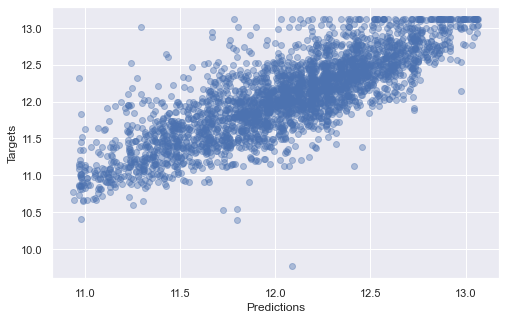

RMSE: 0.316465399742974
MAE: 0.2380791113267182
testing data


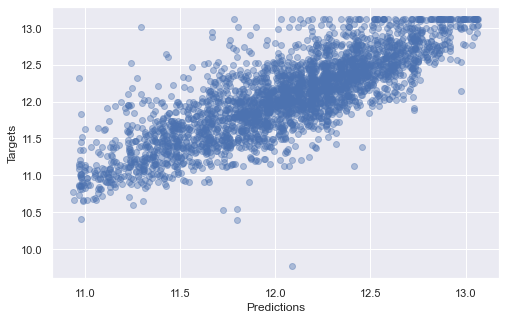

RMSE: 0.316465399742974
MAE: 0.2380791113267182


In [29]:
print('training data')
y_hat = rfr.predict(x_validate)

plt.figure(figsize=(8,5))
plt.scatter(y_hat, y_validate, alpha=.4)
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.show()

print('RMSE:', np.sqrt(mean_squared_error(y_validate, y_hat)))
print('MAE:', mean_absolute_error(y_validate, y_hat))

print('testing data')
y_hat = rfr.predict(x_validate)

plt.figure(figsize=(8,5))
plt.scatter(y_hat, y_validate, alpha=.4)
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.show()

print('RMSE:', np.sqrt(mean_squared_error(y_validate, y_hat)))
print('MAE:', mean_absolute_error(y_validate, y_hat))

In [30]:
y_table = y_validate.copy()
y_table['actual y'] = np.exp(y_table['log_median_house_value'])
y_table['predicted y'] = np.exp(y_hat)
y_table['difference'] = np.abs(y_table['actual y']-y_table['predicted y'])
y_table['difference %'] = y_table['difference']/y_table['predicted y']

print('mean % difference: {}'.format(y_table['difference %'].mean()))
print('mean difference: {}'.format(y_table['difference'].mean()))
y_table

mean % difference: 0.25368441770080546
mean difference: 45610.44438067156


,log_median_house_value,actual y,predicted y,difference,difference %
17954,12.191974,197200.0,239565.032643,42365.032643,0.176841
2484,10.915088,55000.0,60473.045260,5473.045260,0.090504
18868,12.690657,324700.0,368216.616249,43516.616249,0.118182
989,12.286731,216800.0,208076.107679,8723.892321,0.041926
733,12.145792,188300.0,258952.924989,70652.924989,0.272841
...,...,...,...,...,...
19819,11.656160,115400.0,107820.311015,7579.688985,0.070299
4367,12.023951,166700.0,138868.904603,27831.095397,0.200413
2335,11.800358,133300.0,107967.435152,25332.564848,0.234632
15391,12.038246,169100.0,217316.545973,48216.545973,0.221872


## Elastic Net regression model
Elastic Net is created to mix both LASSO and Ridge, in which the penalty term is a combination of l1 and l2 norm regularization terms

In [31]:
enr = ElasticNet()

param_grid = {'alpha': [0.1,0.2, 0.4, 0.7, 1],
             'l1_ratio':[0.1, 0.2, 0.4, 0.7, 1]}

gridsearch_enr = GridSearchCV(estimator = enr,
                     param_grid = param_grid,
                     scoring = 'neg_root_mean_squared_error',
                     n_jobs = 6,
                     cv = None,
                     refit= True, 
                     return_train_score = False)

gridsearch_enr.fit(x_train.values.squeeze(), y_train.values.squeeze())

GridSearchCV(estimator=ElasticNet(), n_jobs=6,
             param_grid={'alpha': [0.1, 0.2, 0.4, 0.7, 1],
                         'l1_ratio': [0.1, 0.2, 0.4, 0.7, 1]},
             scoring='neg_root_mean_squared_error')

In [32]:
print(gridsearch_enr.best_params_)

{'alpha': 0.1, 'l1_ratio': 0.1}


training data


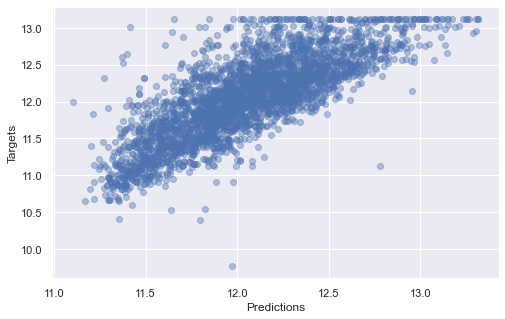

RMSE: 0.3452281575490217
MAE: 0.2675653860958694
testing data


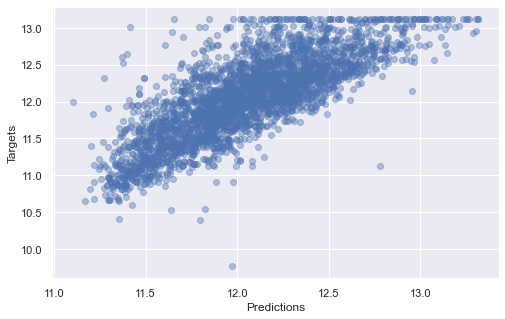

RMSE: 0.3452281575490217
MAE: 0.2675653860958694


In [33]:
print('training data')
y_hat = gridsearch_enr.best_estimator_.predict(x_validate)

plt.figure(figsize=(8,5))
plt.scatter(y_hat, y_validate, alpha=.4)
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.show()

print('RMSE:', np.sqrt(mean_squared_error(y_validate, y_hat)))
print('MAE:', mean_absolute_error(y_validate, y_hat))

print('testing data')
y_hat = gridsearch_enr.best_estimator_.predict(x_validate)

plt.figure(figsize=(8,5))
plt.scatter(y_hat, y_validate, alpha=.4)
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.show()

print('RMSE:', np.sqrt(mean_squared_error(y_validate, y_hat)))
print('MAE:', mean_absolute_error(y_validate, y_hat))

In [34]:
y_table = y_validate.copy()
y_table['actual y'] = np.exp(y_table['log_median_house_value'])
y_table['predicted y'] = np.exp(y_hat)
y_table['difference'] = np.abs(y_table['actual y']-y_table['predicted y'])
y_table['difference %'] = y_table['difference']/y_table['predicted y']

print('mean % difference: {}'.format(y_table['difference %'].mean()))
print('mean difference: {}'.format(y_table['difference'].mean()))
y_table

mean % difference: 0.2888472170234915
mean difference: 51183.6118962604


,log_median_house_value,actual y,predicted y,difference,difference %
17954,12.191974,197200.0,191421.310713,5778.689287,0.030188
2484,10.915088,55000.0,93835.150686,38835.150686,0.413866
18868,12.690657,324700.0,340926.996098,16226.996098,0.047597
989,12.286731,216800.0,182901.273747,33898.726253,0.185339
733,12.145792,188300.0,240006.205851,51706.205851,0.215437
...,...,...,...,...,...
19819,11.656160,115400.0,104762.908975,10637.091025,0.101535
4367,12.023951,166700.0,133866.393870,32833.606130,0.245271
2335,11.800358,133300.0,115096.050384,18203.949616,0.158163
15391,12.038246,169100.0,180912.412368,11812.412368,0.065294


# Testing the model
 The best model is random forest regressor 

training data


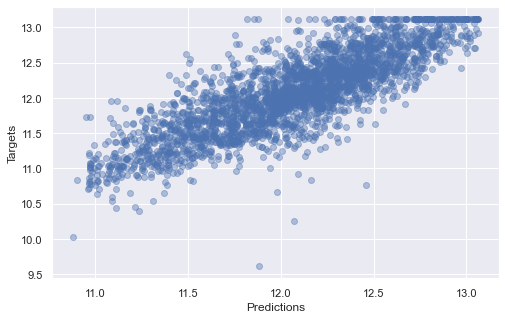

RMSE: 0.3140799467872268
MAE: 0.2394131018530973
testing data


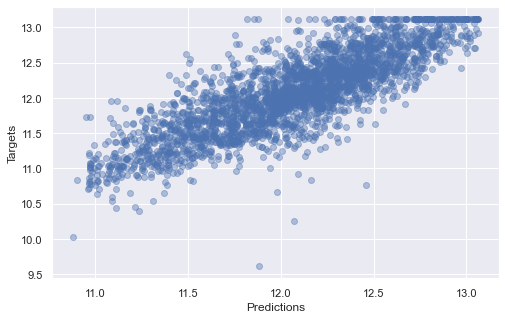

RMSE: 0.3140799467872268
MAE: 0.2394131018530973


In [36]:
print('training data')
y_hat = rfr.predict(x_test)

plt.figure(figsize=(8,5))
plt.scatter(y_hat, y_test, alpha=.4)
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.show()

print('RMSE:', np.sqrt(mean_squared_error(y_test, y_hat)))
print('MAE:', mean_absolute_error(y_test, y_hat))

print('testing data')
y_hat = rfr.predict(x_test)

plt.figure(figsize=(8,5))
plt.scatter(y_hat, y_test, alpha=.4)
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.show()

print('RMSE:', np.sqrt(mean_squared_error(y_test, y_hat)))
print('MAE:', mean_absolute_error(y_test, y_hat))

In [37]:
y_table = y_test.copy()
y_table['actual y'] = np.exp(y_table['log_median_house_value'])
y_table['predicted y'] = np.exp(y_hat)
y_table['difference'] = np.abs(y_table['actual y']-y_table['predicted y'])
y_table['difference %'] = y_table['difference']/y_table['predicted y']

print('mean % difference: {}'.format(y_table['difference %'].mean()))
print('mean difference: {}'.format(y_table['difference'].mean()))
y_table

mean % difference: 0.25223926469851443
mean difference: 47065.612931953656


,log_median_house_value,actual y,predicted y,difference,difference %
19478,11.412000,90400.0,128247.217226,37847.217226,0.295111
6131,12.323411,224900.0,257174.829257,32274.829257,0.125498
15568,12.429216,250000.0,166828.220168,83171.779832,0.498547
17957,12.771102,351900.0,202235.225766,149664.774234,0.740053
16101,11.804101,133800.0,147577.491502,13777.491502,0.093358
...,...,...,...,...,...
15616,12.733165,338800.0,309840.640843,28959.359157,0.093465
12488,11.119883,67500.0,59243.309696,8256.690304,0.139369
17557,12.705028,329400.0,320645.346056,8754.653944,0.027303
5848,11.962726,156800.0,154540.320217,2259.679783,0.014622


# Conclusions


## Results

| Model | rmse  | mae  | mean % error | mean error |
|---:|:-------------|:-----------|:------|:------|
| Linear regression | 0.332  | 0.256 | 0.276   | 49411.162  |
| Decision Tree | 0.325  | 0.584  | 0.263  | 47417.603    |
| Random Forest | 0.316  | 0.238    | 0.253   | 45610.444   |
| Lasso regression | 0.345  | 0.267   | 0.289  | 51183.611


**linear regression(Ordinary Least Squares)**

Second worst performing model but gets the job done. Difficult for a dataset with only 10 columns of data. About 25% error from the observed values.

**Decision Tree**

Second only to Random Forest. Not a good regression model even after being tuned because predicted values look discrete rather than continuous. 

**Random Forest**

Best performing model at 25% error 

**Lasso regression**

Worst performing model despite being tuned. Probably due to the low number of features

**Comments**

There are obvious limitations in predicting continuous data with tree based models. As seen in the scatter plots of the predicted data, vertical lines correspond with the predicted data, this shows that the data is predicted in discrete segments rather than continuously like in OLS.

With more features, all the regression models would no doubt be better. Which will be seen in part 5

## Suggestions for improvement

The most important features are income and geographical related features. A feature that measured the distance to the nearest city could have been a better variable than distance to each city because it seems value of houses decrease going away from cities. A second feature that measured the distance to the coast would also no doubt be a good predictor. 

Several features such as bedrooms/household and rooms/household were excluded from the regression due to high correlation with income, in retrospect while they are correlated, there is no logical dependence between the two of these features. Income measures the amount of salary, while the other describes characteristics/qualities of the building that affect it's price. Additional features such as area of different rooms (an important variable in real estate) and address would be exceedingly useful to this project but do not exist in the dataset.

The random forest model was not tuned due to the impractical waiting time to train and test the models with the gridsearch. If time permitted, tuning this model would deliver the best model